# Graph(s) of our Water Quality Network 
This jupyter notebook has all networkx processing stuff in it. From here, we can figure out how to subset our graph and weight things, etc.

## Getting Our Bipartite 

In [1]:
import time
import random
import decimal
import powerlaw
import matplotlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import graph_creation_functions as fcns
from networkx.algorithms import community as comm
%matplotlib inline

In [2]:
site_pollutant_graph = fcns.read_in_multi_bipartite_graph("../Graphs/bipartite_CA.tsv")

In [3]:
sites, pollutants = fcns.get_bipartite_sets(site_pollutant_graph)

In [4]:
sp_single_graph = fcns.multi_to_single_graph_bipartite(site_pollutant_graph)

In [5]:
site_graph, pollutant_graph = fcns.get_projections(sp_single_graph, sites, pollutants)

In [6]:
def print_graph_info(graph, is_projection=False):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of links:", graph.number_of_edges())
    print("Average degree :", graph.number_of_edges()/graph.number_of_nodes())
    if type(graph) == nx.Graph:
        print("Average weight :", np.mean(list(nx.get_edge_attributes(graph,
                                                                      "Weight").values())))
        if is_projection:
            print("Clustering coef:", np.mean(list(nx.clustering(graph).values())))

In [7]:
print("Multi-Link Bipartite")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print_graph_info(site_pollutant_graph)
print("")
print("Single-Link Bipartite")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print_graph_info(sp_single_graph)
print("")
print("Site Projection Information")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print_graph_info(site_graph, True)
print("")
print("Pollutant Projection Information")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print_graph_info(pollutant_graph, True)

Multi-Link Bipartite
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of nodes: 824
Number of links: 9563
Average degree : 11.605582524271844

Single-Link Bipartite
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of nodes: 824
Number of links: 2453
Average degree : 2.9769417475728157
Average weight : 3.898491642886262

Site Projection Information
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of nodes: 773
Number of links: 209487
Average degree : 271.0051746442432
Average weight : 1.601412020793653
Clustering coef: 0.9217378535354916

Pollutant Projection Information
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of nodes: 51
Number of links: 474
Average degree : 9.294117647058824
Average weight : 11.11603375527426
Clustering coef: 0.8795542648788249


In [8]:
import operator as op
from functools import reduce
def nCr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer//denom

In [9]:
def plot_loglog(graph, name, nodes=None, is_weight=False):
    if is_weight:
        title = name + " Edge Weight Distribution"
        label = "Weights"
        xlabel = "weight $w$"
        ylabel = "$P(w)$"
        data = list(nx.get_edge_attributes(graph,"Weight").values())
    else:
        title = name + " Degree Distribution"
        label = "Degrees"
        xlabel = "degree $k$"
        ylabel = "$P(k)$"
        if nodes:
            data = [degree[1] for degree in graph.degree if degree[0] in nodes]
        else:
            data = [degree[1] for degree in graph.degree]
    #print("Average:", np.mean(data))
    gamma = None
    
    # Log-Log plot it in bin - taken from Sean's implementation in the first hands-on project
    kmax = max(data)
    kmin = min(data)
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    #print(bin_edges)
    density, _ = np.histogram(data, bins=bin_edges, density=True)
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none', label=label)
    #print(density)
    # Plot the Power Law Fit line
    x_val = x[density > 0]
    y_val = density[density > 0]
    gamma, y_int = np.polyfit(np.log(x_val), np.log(y_val), 1)
    pl_fit = np.exp((gamma)*np.log(x) + y_int)
    plt.loglog(x, pl_fit, label="Power Law")
    
    # Plot the Exponential Fit Line
    avg_k = decimal.Decimal(np.mean(data))
    exp_fit = []
    used_points = []
    for k in range(kmax):
        try:
            val = decimal.Decimal(np.exp(-avg_k)) * decimal.Decimal((avg_k**k)/decimal.Decimal(np.math.factorial(k)))
            exp_fit.append(float(val))
            used_points.append(k)
            
        except Exception as e:
            continue
    plt.loglog(used_points, exp_fit, linestyle='-.', label="Random")
    #print(exp_fit)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title)
    
    top = max(max(exp_fit), max(density))
    #print(plt.ylim())
    add = 0.5 if top < 0.5 else 4
    
    axes = plt.gca()
    
    axes.set_ylim([10**(-6),top+add])
    #plt.ylim(bottom=max(10**(-100), plt.ylim()[0]))
    #print(plt.ylim())
    if title == "Pollutant Projection Degree Distribution":
        plt.legend(loc=3)
    else:
        plt.legend()
    plt.show()
    print(gamma)
    #return gamma

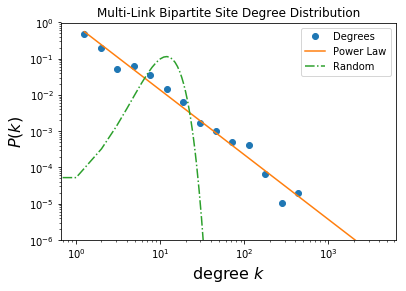

-1.7838267478428467


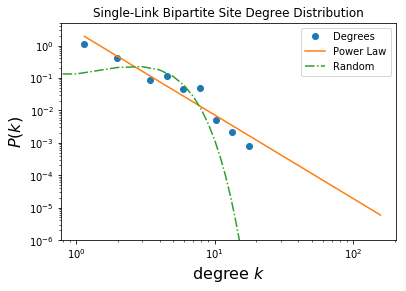

-2.5808182387494107


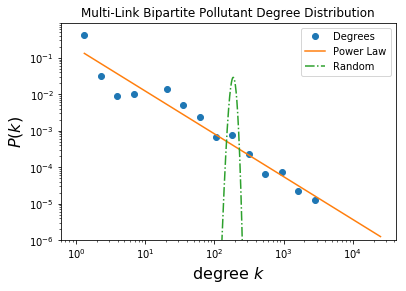

-1.1743238577949124


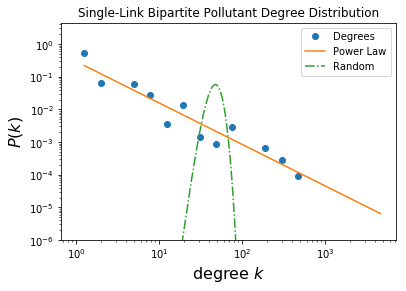

-1.2706091836701798


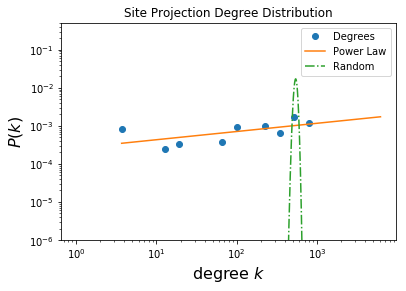

0.21598997155829835


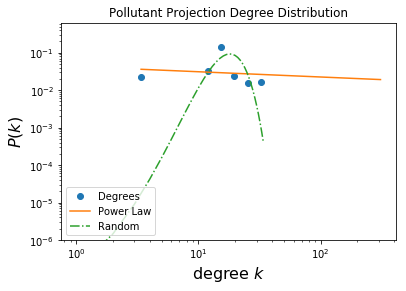

-0.14023203940397946


In [10]:
plot_loglog(site_pollutant_graph, "Multi-Link Bipartite Site", sites)
plot_loglog(sp_single_graph, "Single-Link Bipartite Site", sites)
plot_loglog(site_pollutant_graph, "Multi-Link Bipartite Pollutant", pollutants)
plot_loglog(sp_single_graph, "Single-Link Bipartite Pollutant", pollutants)
plot_loglog(site_graph, "Site Projection")
plot_loglog(pollutant_graph, "Pollutant Projection")

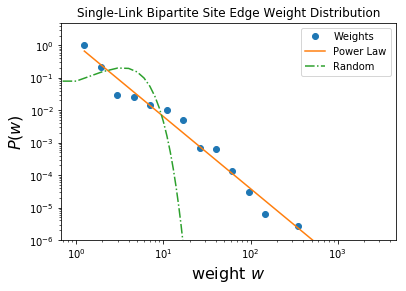

-2.2259074470722906


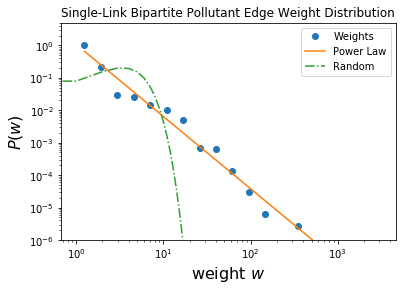

-2.2259074470722906


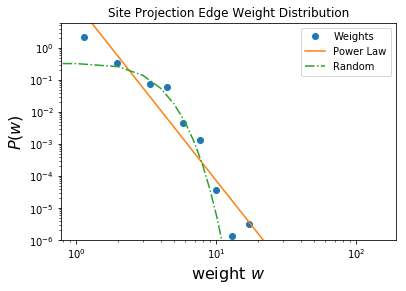

-5.53828789754367


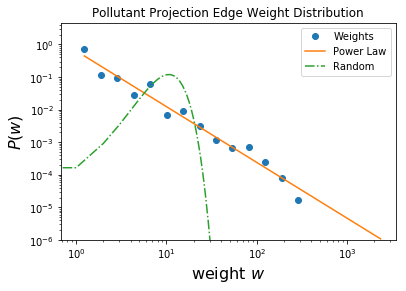

-1.7124574192778865


In [11]:
plot_loglog(sp_single_graph, "Single-Link Bipartite Site", sites, is_weight=True)
plot_loglog(sp_single_graph, "Single-Link Bipartite Pollutant", pollutants, is_weight=True)
plot_loglog(site_graph, "Site Projection", is_weight=True)
plot_loglog(pollutant_graph, "Pollutant Projection", is_weight=True)

# Communities

In [12]:
def get_partitions(graph):
    communities = comm.greedy_modularity_communities(graph)
    partitions = {}
    for i,community in enumerate(communities):
        for node in community:
            partitions[node] = i
    return partitions, communities

In [13]:
def write_partitions(partitions, filename):
    with open(filename, 'w') as file:
        for node in partitions:
            file.write("{}\t{}\n".format(node, partitions[node]))

In [14]:
pollutant_partitions, pollutant_communities = get_partitions(pollutant_graph)
write_partitions(pollutant_partitions, "Partitions/pollutant_partitions.tsv")

In [15]:
site_partitions, site_communities = get_partitions(site_graph)
write_partitions(site_partitions, "Partitions/site_partitions.tsv")

# Creating a null model

In [16]:
degrees = sp_single_graph.degree
null_graph = nx.Graph()
null_graph.add_nodes_from(list(sp_single_graph.nodes))

edge_list = []
rand_degrees = {}


pollutants_by_largest_degree = [item[0] for item in sorted([info for info in dict(sp_single_graph.degree).items() if info[0] in pollutants],
                                 key=lambda x:x[1], reverse=True)]
usable_sites = sites.copy()
for pollutant in pollutants_by_largest_degree:
    used_sites = []
    rand_degrees[pollutant] = 0
    rand_sites = random.sample(usable_sites, degrees[pollutant])
    for site in rand_sites:
        if site not in rand_degrees:
            rand_degrees[site] = 0
        elif rand_degrees[site] == degrees[site]:
                continue
        rand_degrees[pollutant] += 1
        rand_degrees[site] += 1
        edge_list.append((pollutant, site))
        used_sites.append(site)
        if rand_degrees[site] == degrees[site]:
            usable_sites.remove(site)
    
    if rand_degrees[pollutant] < degrees[pollutant]:
        print("{} vs {}".format(rand_degrees[pollutant], degrees[pollutant]))
        print(usable_sites)
        print(used_sites)
        remaining_sites = list(set(usable_sites).difference(set(used_sites)))
        print(remaining_sites)
        random.shuffle(remaining_sites)
        while rand_degrees[pollutant] < degrees[pollutant]:
            site = remaining_sites.pop()
            if site not in rand_degrees:
                rand_degrees[site] = 0
            rand_degrees[pollutant] += 1
            rand_degrees[site] += 1
            edge_list.append((pollutant, site))
            used_sites.append(site)
            if rand_degrees[site] == degrees[site]:
                usable_sites.remove(site)
null_graph.add_edges_from(edge_list)

In [17]:
for key in rand_degrees:
    if degrees[key] != rand_degrees[key]:
        print("{:>15}: Needed {:>3} vs Have {:>3}".format(key, degrees[key], rand_degrees[key]))

In [18]:
null_site_graph, null_pollutant_graph = fcns.get_projections(null_graph, sites, pollutants)
nx.write_edgelist(G=null_pollutant_graph, path="Graphs/Null_Pollutant_Graph.tsv", delimiter="\t", data=False)
nx.write_edgelist(G=null_site_graph, path="Graphs/Null_Site_Graph.tsv", delimiter="\t", data=False)

In [19]:
null_p_partitions, null_p_communities = get_partitions(null_pollutant_graph)
null_s_partitions, null_s_communities = get_partitions(null_site_graph)

In [20]:
write_partitions(null_p_partitions, "Partitions/null_pollutant_partitions.tsv")
write_partitions(null_s_partitions, "Partitions/null_site_partitions.tsv")

In [21]:
print("Modularity of real:", comm.modularity(pollutant_graph, pollutant_communities))

Modularity of real: 0.3533354697430972


In [22]:
print("Modularity of null:", comm.modularity(null_pollutant_graph, null_p_communities))

Modularity of null: 0.14774113426799088


In [36]:
fcns.write_graph_to_file("Graphs/Null_bipartite.tsv", null_graph, data=False)
fcns.write_graph_to_file("Graphs/Null_Pollutant_Graph.tsv", null_pollutant_graph, data=False)

In [37]:
def get_community_strength(graph, partitions):
    communities = set(partitions.values())
    links_in_out = {community:{"In":0, "Out":0} for community in communities}
    
    for (node1, node2) in graph.edges:
        comm1 = partitions[node1]
        comm2 = partitions[node2]
        if comm1 == comm2:
            links_in_out[comm1]["In"] += 2
        else:
            links_in_out[comm1]["Out"] += 1
            links_in_out[comm2]["Out"] += 1
            
    print("   In\tOut")
    for i in communities:
        print("{}: {:^3}\t{:^3}".format(i, links_in_out[i]["In"], links_in_out[i]["Out"]))
        
    return links_in_out

In [38]:
in_out_null = get_community_strength(null_pollutant_graph, partitions=null_p_partitions)

   In	Out
0: 584	239
1: 350	239


In [39]:
in_out_real = get_community_strength(pollutant_graph, partitions=pollutant_partitions)

   In	Out
0: 514	84 
1: 210	 4 
2: 56 	80 
